In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/Shareddrives/group12 cs4824/code")

Mounted at /content/drive


In [2]:
# standard imports
import numpy as np
import pandas as pd
###### special from sklearn ######
from sklearn import svm
from numpy import genfromtxt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

In [3]:
# Import our data
data = pd.read_csv("music_genre.csv")
print(f"{data.shape[0]} rows, {data.shape[1]} columns")
# Check out the dataset
data.head(10)


50005 rows, 18 columns


,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.792000,A#,0.1150,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.950000,D,0.1240,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.011800,G#,0.5340,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.002530,C#,0.1570,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.909000,F#,0.1570,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
5,89064.0,Axel Boman,Hello,47.0,0.00523,0.755,519468.0,0.731,0.854000,D,0.2160,-10.517,Minor,0.0412,?,4-Apr,0.614,Electronic
6,43760.0,Jordan Comolli,Clash,46.0,0.02890,0.572,214408.0,0.803,0.000008,B,0.1060,-4.294,Major,0.3510,149.995,4-Apr,0.230,Electronic
7,30738.0,Hraach,Delirio,43.0,0.02970,0.809,416132.0,0.706,0.903000,G,0.0635,-9.339,Minor,0.0484,120.008,4-Apr,0.761,Electronic
8,84950.0,Kayzo,NEVER ALONE,39.0,0.00299,0.509,292800.0,0.921,0.000276,F,0.1780,-3.175,Minor,0.2680,149.94799999999998,4-Apr,0.273,Electronic
9,56950.0,Shlump,Lazer Beam,22.0,0.00934,0.578,204800.0,0.731,0.011200,A,0.1110,-7.091,Minor,0.1730,139.933,4-Apr,0.203,Electronic


In [4]:
data = data.dropna(axis=0)
df=data.drop(['instance_id','artist_name', 'track_name','obtained_date'], axis=1)
# Feature Selection
df.drop(['key', 'mode'], axis=1, inplace=True)
#df[['key','mode']] = OrdinalEncoder().fit_transform(df[['key','mode']])
df['tempo'].replace(to_replace = '?', value =-1.0, inplace=True)
df['instrumentalness'].replace(to_replace = 0.0, value =-1.0, inplace=True)
df['tempo'] = pd.to_numeric(df['tempo'])
imp = SimpleImputer(missing_values = -1.0, strategy = 'median')
df[['tempo','duration_ms','instrumentalness']] = imp.fit_transform(df[['tempo','duration_ms','instrumentalness']])
scaler = StandardScaler()
df.iloc[:,:-1] = scaler.fit_transform(df.iloc[:,:-1].values)
data=df
data.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,music_genre
0,-1.108003,-0.883886,0.524878,-0.154369,1.289876,1.876078,-0.488113,0.638132,-0.185322,-0.655420,1.225073,Electronic
1,-0.850633,-0.860390,0.356933,-0.239968,1.097101,2.364033,-0.432433,0.339248,-0.627258,-0.170027,0.302431,Electronic
2,-1.043661,-0.888632,0.345737,-0.265269,0.586813,-0.533434,2.104140,0.732892,-0.582867,0.276811,-0.498812,Electronic
3,-0.657606,-0.823184,1.207853,-0.725393,0.378918,-0.562063,-0.228269,0.752201,1.434452,0.277499,-0.753752,Electronic
4,-0.786291,-0.883974,0.446504,-0.201488,-0.048212,2.237412,-0.228269,0.465324,-0.515787,0.862942,-0.539278,Electronic


In [5]:
#Prepare splits
dataTrain = data.sample(frac=0.7, random_state=1)    
dataTest = data.drop(dataTrain.index) 
xTrain = dataTrain.drop(['music_genre'], axis=1).values
yTrain = dataTrain['music_genre'].values
xTest = dataTest.drop(['music_genre'], axis=1).values
yTest = dataTest['music_genre'].values

0.6288285714285714

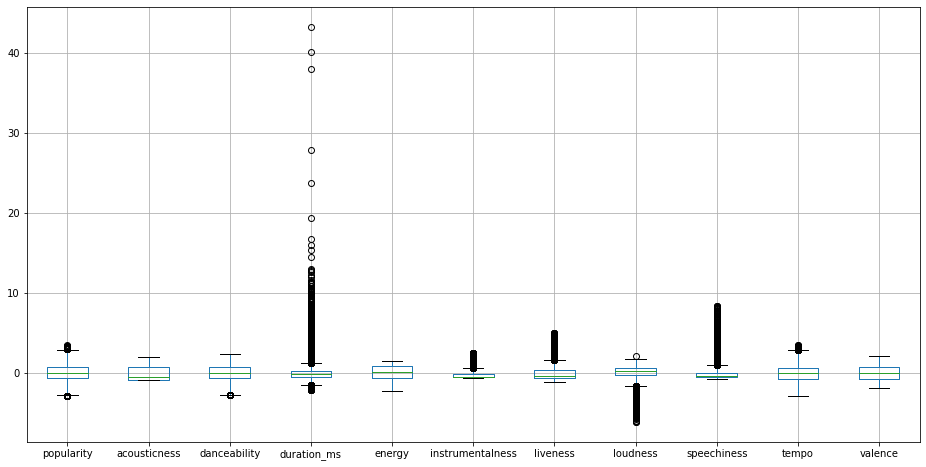

In [7]:
#SVM
boxplot = data.boxplot(figsize=(16,8))  
clf = svm.SVC(decision_function_shape='ovo', kernel = 'rbf', C=5)
clf.fit(xTrain, yTrain)
clf.score(xTrain,yTrain)
#clf.score(xTest, yTest)
#scores = cross_val_score(clf, xTest, yTest, cv=5)
#scores

In [ ]:
#Feature Selection
sfs = SequentialFeatureSelector(clf, n_features_to_select=1)
sfs.fit(xTrain, yTrain)
sfs.get_feature_names_out(list(data.columns))

KeyboardInterrupt: ignored

In [ ]:
# Tunning
# Set the parameters by cross-validation
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": ['scale'], "C": [4,5,6]}
]

scores = ["accuracy"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf2 = GridSearchCV(clf, tuned_parameters, scoring="%s" % score)
    clf2.fit(xTrain, yTrain)

    print("Best parameters set found on development set:")
    print()
    print(clf2.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf2.cv_results_["mean_test_score"]
    stds = clf2.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf2.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yTest, clf2.predict(xTest)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}

Grid scores on development set:

0.577 (+/-0.011) for {'C': 4, 'gamma': 'scale', 'kernel': 'rbf'}
0.577 (+/-0.011) for {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
0.577 (+/-0.012) for {'C': 6, 'gamma': 'scale', 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

 Alternative       0.45      0.38      0.41      1496
       Anime       0.76      0.74      0.75      1492
       Blues       0.61      0.55      0.58      1512
   Classical       0.84      0.86      0.85      1533
     Country       0.51      0.54      0.52      1511
  Electronic       0.66      0.62      0.64      1462
     Hip-Hop       0.44      0.51      0.47      1476
        Jazz       0.54      0.49      0.52      1482
         Rap    

In [ ]:
pip install spotipy --upgrade

     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 138 kB 51.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
cid = '10f92907722c44d5a24ed6486e961379'
secret = 'b1c12d2638ed4996a4b72ab313f49f1b'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager
=
client_credentials_manager)

In [ ]:
artist= input("Enter artist name: ")
track= input("Enter track name: ")

found = sp.search(q='artist:' + artist + ' track:' + track, type='track')
trackId = found['tracks']['items'][0]['id']

audio_features = sp.audio_features(trackId)[0]
sample = pd.DataFrame.from_dict([audio_features])
df_sample = data.median(numeric_only=True)
df_sample['popularity'] = found['tracks']['items'][0]['popularity'] #0
df_sample['danceability'] = sample['danceability'].values[0] #2
df_sample['energy'] = sample['energy'].values[0] #4
df_sample['loudness'] = sample['loudness'].values[0] #7
df_sample['speechiness'] = sample['speechiness'].values[0] #8
df_sample['acousticness'] = sample['acousticness'].values[0] #1
df_sample['instrumentalness'] = sample['instrumentalness'].values[0] #5
df_sample['valence'] = sample['valence'].values[0] #10
df_sample['tempo'] = sample['tempo'].values[0] #9
df_sample['liveness'] = sample['liveness'].values[0] #6
df_sample['duration_ms'] = sample['duration_ms'].values[0] #3
df_sample = scaler.transform([df_sample])

print("Predicted Genre: ",clf.predict(df_sample)[0])

Enter artist name: Gorillaz
Enter track name: Feel Good Inc
Predicted Genre:  Rap
